# Movie Recommendations

Recommendation systems are used to filter among a catalog of possibilities, which ones should be presented to the user. Those systems can be used to enhance the user experience by making the content available to user relavant. In this project, we're going to explore a <a href="https://grouplens.org/datasets/movielens/25m/">movie dataset</a>, and present some of the key types of recommendations systems.

## 1. Importing and inspecting data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We start by importing and checking our data.

In [2]:
movies = pd.read_parquet("../data/movies.parquet")
ratings = pd.read_parquet("../data/ratings.parquet")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
movies.duplicated().sum()

0

In [10]:
ratings.duplicated().sum()

0

In [11]:
# There are duplicated titles
movies['title'].duplicated().sum()

98

We don't have any nulls or duplicated data. But be mindful that there are duplicated movies titles.

## 2. Feature extraction

We are going to extract the year from the title of the movie and create genres columns.

In [12]:
# Extracting year from title with regex
movies["year"] = movies['title'].str.extract(r'\((\d{4})\)')

In [13]:
# Creating genres columns
genres = movies['genres'].str.get_dummies('|')

We could convert the timestamp to datetime to get temporal features. But for now, we stick to those features.

## 3. EDA

Let's explore the dataset to get some insights.

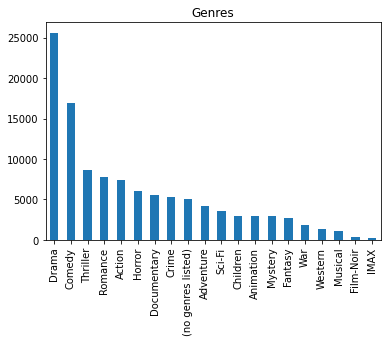

In [14]:
# Most present genres
genres.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Genres')
plt.show()

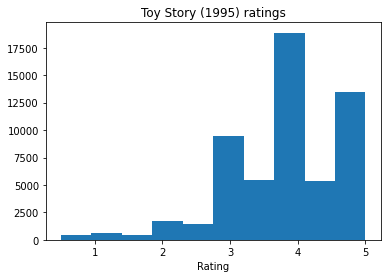

In [15]:
# Choose a movie, and check the rating distribution
toy_id = movies.loc[movies['title'] == 'Toy Story (1995)', 'movieId'].values[0]
toy_ratings = ratings.loc[ratings['movieId'] == toy_id, 'rating']

plt.hist(toy_ratings)
plt.xlabel('Rating')
plt.title('Toy Story (1995) ratings')
plt.show()

In [16]:
# Ratings count - What are the top 5% most rated movies?

ratings_count = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
ratings_count_norm = ratings_count / ratings_count.sum()
top_5 = ratings_count_norm[ratings_count_norm.cumsum() < 0.05].to_frame()
top_5.merge(right=movies[['movieId', 'title']], left_index=True, right_on='movieId')[['title']]

,title
351,Forrest Gump (1994)
314,"Shawshank Redemption, The (1994)"
292,Pulp Fiction (1994)
585,"Silence of the Lambs, The (1991)"
2480,"Matrix, The (1999)"
257,Star Wars: Episode IV - A New Hope (1977)
475,Jurassic Park (1993)
522,Schindler's List (1993)
108,Braveheart (1995)
2867,Fight Club (1999)


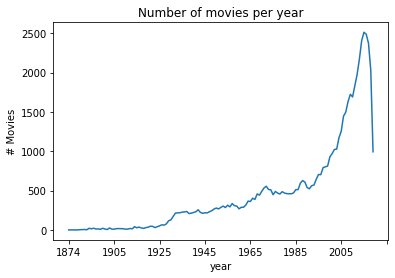

In [17]:
# Movies per year

movies.groupby('year').size().plot()
plt.ylabel('# Movies')
plt.title('Number of movies per year')
plt.show()

In [18]:
# We could explore more questions:
# Movie time series per gender
# What's the highest mean rating movie?

## 4. Search engine

Our first task is to make a **search engine**. When a user type a movie title, a function search the most similar rows in the database. First we clean our titles to get only letters and numbers and convert every instance in a vector using **TF-IDF**. Then, we compare those vectors using **cosine similarity** and return the best items.

In [19]:
# Cleaning titles with regex

import re

def clean(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

movies["clean_titles"] = movies["title"].apply(clean)

In [20]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 3))

titles_vec = vec.fit_transform(movies["clean_titles"])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title):
    title = clean(title)
    query_vec = vec.transform([title])
    similarity = cosine_similarity(query_vec, titles_vec).flatten()
    
    # Selecting top 5 movies
    idx = np.argpartition(similarity, kth=-5)[-5:]

    results = movies.iloc[idx][::-1]
    return results

In [22]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(description="Movie title", value="Toy Story 1995", disabled=False)
movie_output = widgets.Output()

def when_type(data):
    with movie_output:
        movie_output.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(when_type, names='value')

In [23]:
display(movie_input, movie_output)

Text(value='Toy Story 1995', description='Movie title')

Output()

## 5. Recomendation systems

### 5.1 Non-personalized recomendations

Our first recommenders are **non-personalized** in the sense that they are not based on the individual user information. The information used can be the global watch rate, ratings, seem together movies or content based recommendations. Those systems are useful as product showcase.

#### 5.1.1 High rate/watch movies

A first recommender can be made by ranking the best reviewed movies, but filtering by only movies with a certain number of reviews.

In [24]:
# Movies with more than 500 reviews

review_count = ratings["movieId"].value_counts()
pop_movies = review_count[review_count > 3000].index

In [25]:
# Best reviewed movies

pop_movies_ratings = ratings[ratings["movieId"].isin(pop_movies)]
movie_rec = pop_movies_ratings[["rating", "movieId"]].groupby("movieId").mean().sort_values(by="rating", 
                                                                           ascending=False).reset_index()


In [26]:
movie_rec.merge(right=movies[["movieId", "title"]], on="movieId").head(10)

,movieId,rating,title
0,318,4.413576,"Shawshank Redemption, The (1994)"
1,858,4.324336,"Godfather, The (1972)"
2,50,4.284353,"Usual Suspects, The (1995)"
3,1221,4.261759,"Godfather: Part II, The (1974)"
4,2019,4.254769,Seven Samurai (Shichinin no samurai) (1954)
5,527,4.247579,Schindler's List (1993)
6,1203,4.243014,12 Angry Men (1957)
7,904,4.237948,Rear Window (1954)
8,2959,4.228311,Fight Club (1999)
9,1193,4.218662,One Flew Over the Cuckoo's Nest (1975)


It surelly works, but is *pretty generic*.

#### 5.1.2 Most seem together

If a some users usually watch some movies together, those are probably a good recomendation for another user.
The problem of this approach is the memory usage required to compute and store the permutations between the movies. The code used to generate a database with the permutations is commented due to time requirements, but once precomputed, our task is a simple query.

In [27]:
# from itertools import permutations

# def create_pairs(x):
#     pairs = pd.DataFrame(list(permutations(x.values, 2)), columns=["movie_a", "movie_b"])
#     return pairs

# # Getting a smaller sample from ratings
# n_users = 1000
# selected_users = ratings['userId'].sample(n_users, replace=False).values
# small_ratings = ratings.loc[ratings["userId"].isin(selected_users), ["userId", "movieId"]]

# # Get a smaller movie subset
# small_ratings_count = small_ratings["movieId"].value_counts()
# small_ratings_count = small_ratings_count[small_ratings_count > 250]
# smaller_ratings = small_ratings[small_ratings["movieId"].isin(small_ratings_count.index)]

# # Counting the pairs movies watched by the same user
# pair_counts = smaller_ratings.groupby("userId")["movieId"].apply(create_pairs).reset_index(drop=True)

# # Saving the results
# pair_counts.to_parquet("../data/pair_counts.parquet")

In [28]:
# Importing the permutations previously generated

pair_counts = pd.read_parquet("../data/pair_counts.parquet")
pair_counts = pair_counts.groupby(["movie_a", "movie_b"]).size().to_frame(name='size').reset_index()

# Getting movie_a titles

pair_counts_a = pair_counts.merge(right=movies[["movieId", "title"]], left_on="movie_a", right_on="movieId")[["title", "movie_b", "size"]]
pair_counts_a = pair_counts_a.rename(columns={"title":"movie_a"})

# Getting movie_b titles
pair_counts_b = pair_counts_a.merge(right=movies[["movieId", "title"]], left_on="movie_b", right_on="movieId")[["movie_a", "title", "size"]]
pair_counts = pair_counts_b.rename(columns={"title":"movie"})

In [29]:
def seem_together_recommendation(movie):
    pairs = pair_counts[pair_counts["movie_a"] == movie]
    pairs_sorted = pairs.sort_values(by="size", ascending=False)[["movie"]]
    return pairs_sorted.head(10)

In [30]:
seem_together_recommendation("Toy Story (1995)")

,movie
10624,Forrest Gump (1994)
8632,Pulp Fiction (1994)
61420,"Matrix, The (1999)"
7304,Star Wars: Episode IV - A New Hope (1977)
13944,Jurassic Park (1993)
18260,"Silence of the Lambs, The (1991)"
9296,"Shawshank Redemption, The (1994)"
37848,Back to the Future (1985)
30212,Raiders of the Lost Ark (Indiana Jones and the...
32536,Star Wars: Episode VI - Return of the Jedi (1983)


Now we are going somewhere. Our recomendations to Toy Story are very non-trivial.

#### 5.1.3 Content-based recommendation

Since we have some information on our product, we can use our descriptors (in this case, the genres) to recommend similar products.

In [31]:
from sklearn.metrics import jaccard_score

def jaccard_similarities_recomendation(movieId):
    """
    Get the jaccard similarities between a movie and all others and sort them.
    Then, get the top 10 recommendations.
    """
    movies_and_genres = movies[['movieId']].join(genres).set_index('movieId')
    movie_row = movies_and_genres.loc[movieId]
    movies_and_genres['similarities'] = movies_and_genres.apply(lambda x: jaccard_score(movie_row, x), axis=1)
    movies_and_genres = movies_and_genres.sort_values(by='similarities', ascending=False)
    
    return movies_and_genres.head(10).join(movies.set_index('movieId'))[['title', 'genres']]

In [32]:
# Testing for the movieId = 1 (Toy Story 1995)
jaccard_similarities_recomendation(1)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
177037,Puss in Book: Trapped in an Epic Tale (2017),Adventure|Animation|Children|Comedy|Fantasy
175625,The Dragon Spell (2016),Adventure|Animation|Children|Comedy|Fantasy
136016,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy
136361,Scooby-Doo! Mask of the Blue Falcon (2012),Adventure|Animation|Children|Comedy|Fantasy
4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
186159,Tangled: Before Ever After (2017),Adventure|Animation|Children|Comedy|Fantasy
186177,Trolls Holiday (2017),Adventure|Animation|Children|Comedy|Fantasy
196693,Dragons: Dawn Of The Dragon Racers (2014),Adventure|Animation|Children|Comedy|Fantasy


It works well when the user is searching for something similar to the watched movie.

### 5.2 Colaborative filtering

Now we are going to use user ratings to create recommendations. Our strategy is to find similar users that liked the movie we just watch. Next we find the movies they liked. With this, we can create a score that takes into account the popularity of the movie - we don't want movies to be recommended just because they are popular.

First we begin by making a prototype and then pack it all in a function and interface.

In [33]:
# Suppose we our user liked the movie with Id 1 (Toy Story)
movie_id = 1

# Users that watched our movie and rated > 4
similar_users = ratings.loc[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4.0), "userId"].unique()

# High rated movies (>4) that our similiar users watched
similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]

# Counting how many users watched our recomendation. Getting the percentage from similar users
similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))

# Restricting ourselves to 10%
similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]

similar_rec_movies_percentage.head(5)

1      1.000000
318    0.445607
260    0.403770
356    0.370215
296    0.367295
Name: movieId, dtype: float64

44.56% of the similar users watched movie with ID 318.

In [34]:
# We don't want movies that are there just because they are already popular

all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
all_users_recs_percentage.head(5)

318     0.342220
296     0.284674
2571    0.244033
356     0.235266
593     0.225909
Name: movieId, dtype: float64

But from *all users*, movie 318 is already liked by 34.22%. Thats probably generic. We should create a score:

$$score = \frac{\text{percentage from similar users}}{\text{percentage from all users}} $$

In [35]:
# Creating a score, sorting by it, and showing the top 10 recs

rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")

rec_percentages[['title']].head(10)

,title
0,Toy Story (1995)
3021,Toy Story 2 (1999)
2264,"Bug's Life, A (1998)"
14813,Toy Story 3 (2010)
4780,"Monsters, Inc. (2001)"
580,Aladdin (1992)
6258,Finding Nemo (2003)
587,Beauty and the Beast (1991)
8246,"Incredibles, The (2004)"


In [36]:
# Wrapping in a function

def colab_recommendations(movieId):
    similar_users = ratings.loc[(ratings["movieId"] == movieId) & (ratings["rating"] > 4.0), "userId"].unique()
    similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]
    similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))
    similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]
    
    all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
    all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
    rec_percentages.columns = ["similar", "all"]
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")
    
    return rec_percentages[['title']].head(10)

In [37]:
movie_input = widgets.Text(description="Movie title", value="The Godfather", disabled=False)
movie_recommendation = widgets.Output()

def when_type(data):
    with movie_recommendation:
        movie_recommendation.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(colab_recommendations(movie_id))

movie_input.observe(when_type, names='value')

In [38]:
display(movie_input, movie_recommendation)

Text(value='Toy Story 1995', description='Movie title')

Output()

# Conclusions and perspectives

We've demonstrated applications of some recommendations systems models. There are other approachs that can be further examinated: item based recommendations with KNN, using SVD to predict ratings and validation tecniques. Nonetheless, the models presented here can with some adjustments be put in production in several situations.